In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks/Kaggle"

import os
%cd "/content/gdrive/My Drive/Colab Notebooks/Kaggle"

/content/gdrive/My Drive/Colab Notebooks/Kaggle


In [ ]:
!kaggle competitions download -c cap-4611-spring-21-assignment-4

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import numpy as np 
import pandas as pd 
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.impute import SimpleImputer

In [ ]:
data = pd.read_csv("train.csv")
data.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,0,-122.22,37.77,40.0,494.0,114.0,547.0,135.0,2.8015,NEAR BAY,114800.0
1,1,-122.29,37.76,18.0,2873.0,763.0,1243.0,663.0,5.1702,NEAR BAY,265400.0
2,2,-118.48,34.23,29.0,3354.0,707.0,1752.0,650.0,4.5484,<1H OCEAN,239900.0
3,3,-122.19,37.80,48.0,1694.0,259.0,610.0,238.0,4.7440,NEAR BAY,257300.0
4,4,-121.93,36.63,33.0,1740.0,342.0,638.0,329.0,3.1912,NEAR OCEAN,319800.0


In [ ]:
data.describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10210.000000,10320.000000,10320.000000,10320.000000,10320.000000
mean,5159.500000,-119.593791,35.647997,28.544477,2652.874031,541.297845,1431.618120,502.993605,3.882051,208222.779845
std,2979.271723,2.005209,2.132319,12.605356,2215.969393,427.866565,1144.035957,388.016806,1.902330,116152.666840
min,0.000000,-124.350000,32.540000,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,14999.000000
25%,2579.750000,-121.810000,33.940000,18.000000,1461.000000,294.250000,786.000000,278.000000,2.583300,120000.000000
50%,5159.500000,-118.535000,34.270000,29.000000,2138.000000,438.000000,1165.000000,413.000000,3.550000,180700.000000
75%,7739.250000,-118.010000,37.720000,37.000000,3144.250000,648.750000,1724.000000,607.000000,4.733575,267225.000000
max,10319.000000,-114.550000,41.920000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10320 non-null  int64  
 1   longitude           10320 non-null  float64
 2   latitude            10320 non-null  float64
 3   housing_median_age  10320 non-null  float64
 4   total_rooms         10320 non-null  float64
 5   total_bedrooms      10210 non-null  float64
 6   population          10320 non-null  float64
 7   households          10320 non-null  float64
 8   median_income       10320 non-null  float64
 9   ocean_proximity     10320 non-null  object 
 10  median_house_value  10320 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 887.0+ KB


**MISSING VALUES**: total_bedrooms has missing values that may need to be addressed. The amount of missing data is fairly low at only 110/103020. Since the amount of data missing is so low, can reasonably try to imputes with a suitable replacement, or drop the affected row.

Imputing will be used in the pipline.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


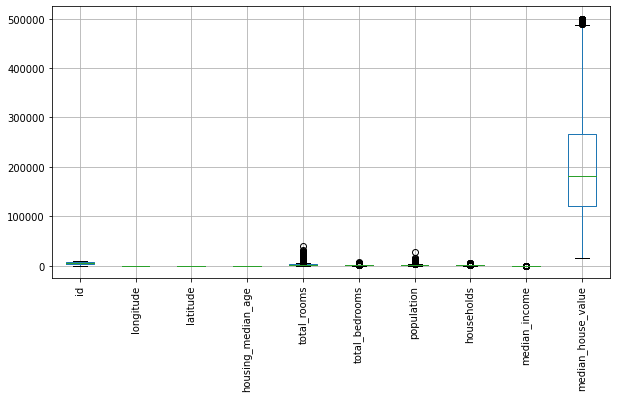

In [ ]:
data.loc[:,].boxplot(figsize=(10,5), rot=90)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


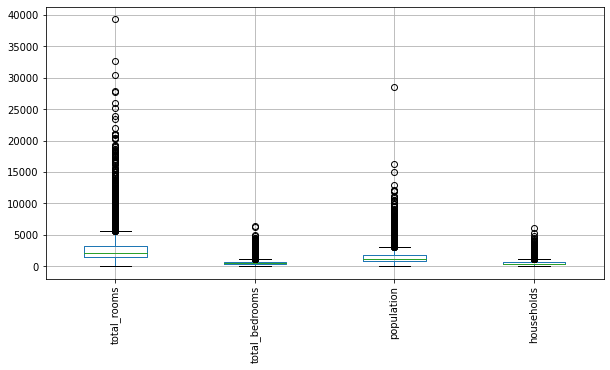

In [ ]:
data.loc[:, data.columns[4:8].to_list()].boxplot(figsize=(10,5), rot=90)

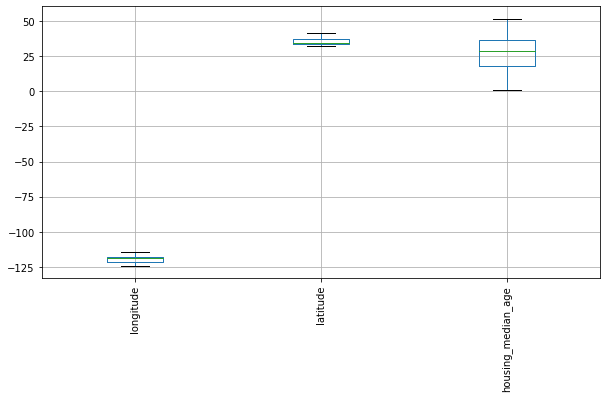

In [ ]:
data.loc[:, data.columns[1:4].to_list()].boxplot(figsize=(10,5), rot=90)

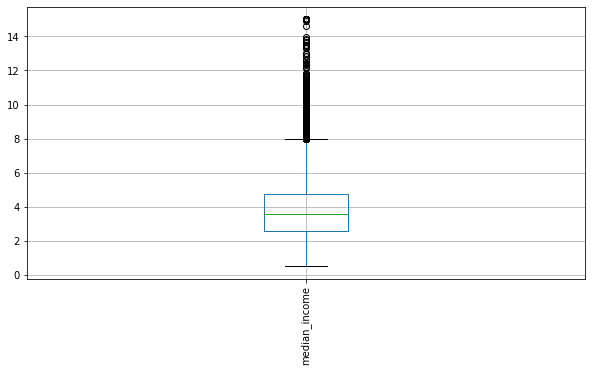

In [ ]:
data.boxplot(column='median_income',figsize=(10,5), rot=90)

**OUTLIERS:** The only outlier seen the a box plots that could be a problem is in population. Howeve this is one point of data and not that far away from the others, so no outlier adjustments will be made.

There is a catagorical feature in this set that need to be converted so Hot encoding will be used.

In [ ]:
features = data.columns[1:-1]
target = data.columns[-1]

X = data.loc[:, features]
y = data.loc[:, target]

In [ ]:
X_encoded = X.copy()
X_encoded = pd.get_dummies(X_encoded, columns=['ocean_proximity'], prefix = ['ocean_proximity'])

X_encoded.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.22,37.77,40.0,494.0,114.0,547.0,135.0,2.8015,0,0,0,1,0
1,-122.29,37.76,18.0,2873.0,763.0,1243.0,663.0,5.1702,0,0,0,1,0
2,-118.48,34.23,29.0,3354.0,707.0,1752.0,650.0,4.5484,1,0,0,0,0
3,-122.19,37.80,48.0,1694.0,259.0,610.0,238.0,4.7440,0,0,0,1,0
4,-121.93,36.63,33.0,1740.0,342.0,638.0,329.0,3.1912,0,0,0,0,1


**Basic Model testing**

,RMSE,RMSE Test
0,68831.249231,69169.395305
1,69028.533122,68930.191066
2,68510.453678,69796.314258
3,68802.004490,69245.241978
4,68235.714339,70255.841586
5,68936.205793,68975.380527
6,68649.524425,69523.157440
7,68516.429257,69812.039788
8,68733.957752,69428.655862
9,67606.476986,71533.776797


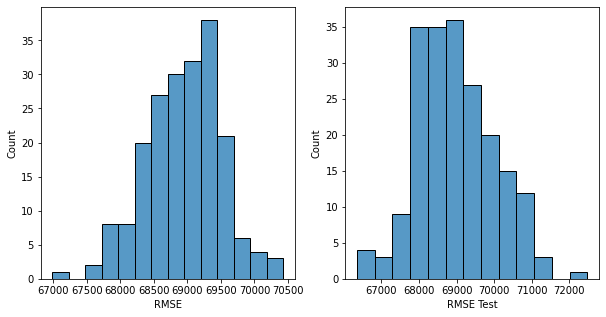

In [ ]:
def modelBaseOLS(X, y):
  RMSE = []
  RMSE_test = []

  for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.35, shuffle=True)
    model = make_pipeline(SimpleImputer(strategy='median'), linear_model.LinearRegression())
    model.fit(X_train,y_train)

    prediction_test = model.predict(X_test)

    RMSE_test.append(metrics.mean_squared_error(y_test, prediction_test, squared=False))

    prediction = model.predict(X_train)

    RMSE.append(metrics.mean_squared_error(y_train, prediction, squared=False))

  return pd.DataFrame({'RMSE': RMSE, 'RMSE Test':RMSE_test})

scores = modelBaseOLS(X, y)
plt.figure(figsize=(10,5))
for c in range(0, scores.shape[1]):
  plt.subplot(1, 2, c+1)
  sns.histplot(scores.iloc[:, c])

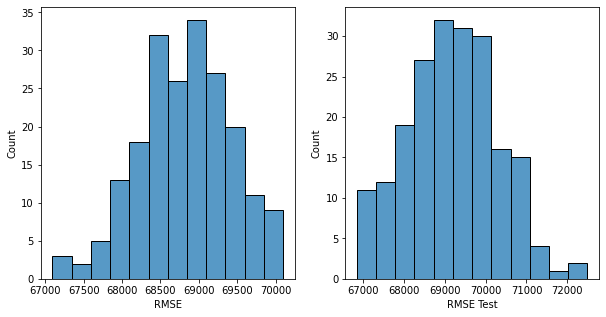

In [ ]:
def modelBaseRidge(X, y):
  RMSE = []
  RMSE_test = []

  for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.35, shuffle=True)
    model = make_pipeline(SimpleImputer(strategy='median'), linear_model.Ridge())
    model.fit(X_train,y_train)

    prediction_test = model.predict(X_test)

    RMSE_test.append(metrics.mean_squared_error(y_test, prediction_test, squared=False))

    prediction = model.predict(X_train)

    RMSE.append(metrics.mean_squared_error(y_train, prediction, squared=False))

  return pd.DataFrame({'RMSE': RMSE, 'RMSE Test':RMSE_test})

scores = modelBaseRidge(X, y)
plt.figure(figsize=(10,5))
for c in range(0, scores.shape[1]):
  plt.subplot(1, 2, c+1)
  sns.histplot(scores.iloc[:, c])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520605758050.1367, tolerance: 9092883587.112139
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2664733648698.414, tolerance: 9081082348.018019
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4483757743930.768, tolerance: 8898262078.369839
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143360506623

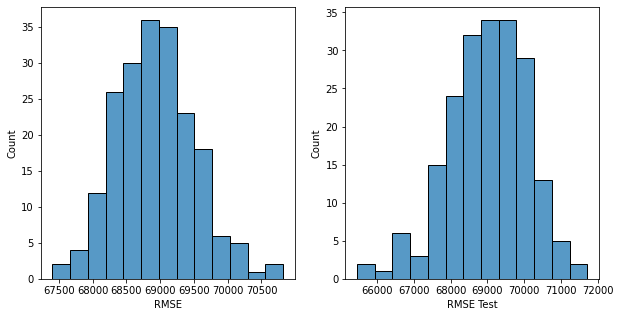

In [ ]:
def modelBaseLasso(X, y):
  RMSE = []
  RMSE_test = []

  for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.35, shuffle=True)
    model = make_pipeline(SimpleImputer(strategy='median'), linear_model.Lasso())
    model.fit(X_train,y_train)

    prediction_test = model.predict(X_test)

    RMSE_test.append(metrics.mean_squared_error(y_test, prediction_test, squared=False))

    prediction = model.predict(X_train)

    RMSE.append(metrics.mean_squared_error(y_train, prediction, squared=False))

  return pd.DataFrame({'RMSE': RMSE, 'RMSE Test':RMSE_test})

scores = modelBaseLasso(X, y)
plt.figure(figsize=(10,5))
for c in range(0, scores.shape[1]):
  plt.subplot(1, 2, c+1)
  sns.histplot(scores.iloc[:, c])

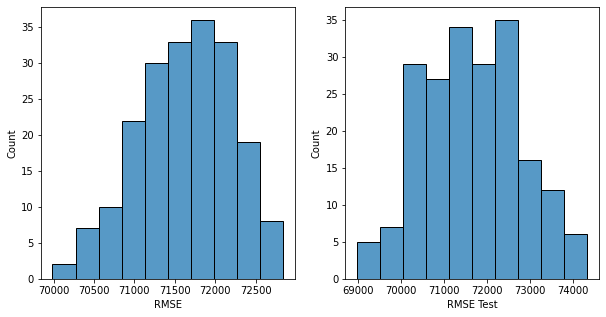

In [ ]:
def modelBaseElastic(X, y):
  RMSE = []
  RMSE_test = []

  for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.35, shuffle=True)
    model = make_pipeline(SimpleImputer(strategy='median'), linear_model.ElasticNet())
    model.fit(X_train,y_train)

    prediction_test = model.predict(X_test)

    RMSE_test.append(metrics.mean_squared_error(y_test, prediction_test, squared=False))

    prediction = model.predict(X_train)

    RMSE.append(metrics.mean_squared_error(y_train, prediction, squared=False))

  return pd.DataFrame({'RMSE': RMSE, 'RMSE Test':RMSE_test})

scores = modelBaseElastic(X, y)
plt.figure(figsize=(10,5))
for c in range(0, scores.shape[1]):
  plt.subplot(1, 2, c+1)
  sns.histplot(scores.iloc[:, c])

In [ ]:
def modelDist(X, y, model):
  RMSE = []
  RMSE_test = []

  for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.35, shuffle=True)
  
    model.fit(X_train,y_train)

    prediction_test = model.predict(X_test)

    RMSE_test.append(metrics.mean_squared_error(y_test, prediction_test, squared=False))

    prediction = model.predict(X_train)

    RMSE.append(metrics.mean_squared_error(y_train, prediction, squared=False))

  return pd.DataFrame({'RMSE': RMSE, 'RMSE Test': RMSE_test})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.35, shuffle=True)

In [ ]:
modelOLS = make_pipeline(SimpleImputer(strategy='median'), linear_model.LinearRegression())
modelOLS.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

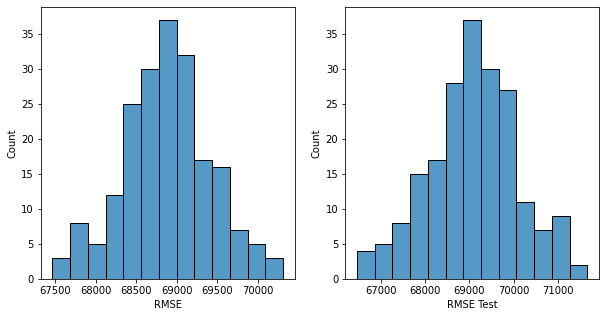

In [ ]:
scores = modelDist(X_encoded, y, modelOLS)
plt.figure(figsize=(10,5))
for c in range(0, scores.shape[1]):
  plt.subplot(1, 2, c+1)
  sns.histplot(scores.iloc[:, c])

I submitted my basic model with handling missing values as medians and hot encoding ocean proximity and passed the benchmark. Based on my ditrabutioin where most of the the RMSE score are to the right of the target, this was probably a lucky run.

In [ ]:
test = pd.read_csv("test.csv")

featuresT = test.columns[1:]

testX = test.loc[:, features]

testX_encoded = testX.copy()
testX_encoded = pd.get_dummies(testX_encoded, columns=['ocean_proximity'], prefix = ['ocean_proximity'])

testX_encoded.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.36,37.94,41.0,2591.0,585.0,1638.0,462.0,1.8220,0,0,0,1,0
1,-118.37,34.16,17.0,4150.0,1148.0,1808.0,1041.0,3.5051,1,0,0,0,0
2,-118.29,33.95,40.0,2808.0,695.0,2357.0,627.0,1.9655,1,0,0,0,0
3,-121.77,38.01,13.0,2983.0,534.0,1417.0,510.0,3.9861,0,1,0,0,0
4,-118.26,34.08,45.0,2174.0,627.0,1992.0,557.0,2.5428,1,0,0,0,0


In [ ]:
probTest = modelOLS.predict(testX_encoded)

output = pd.DataFrame({'id': test.id, 'median_house_value': probTest})
output.to_csv('my_submission.csv', index=False)